In [5]:
# !pip install matplotlib

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt

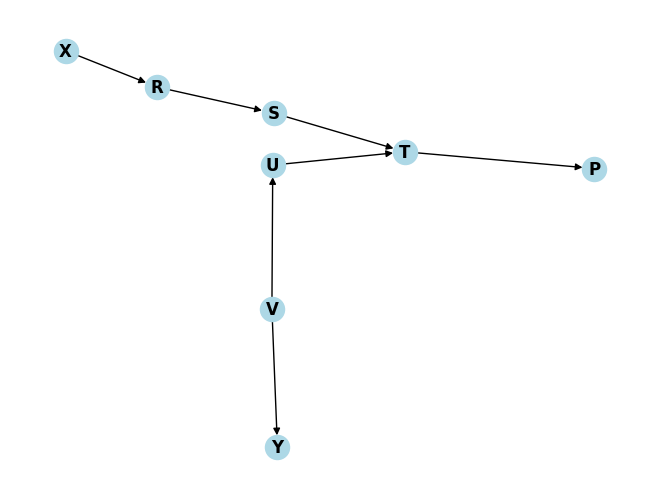

In [11]:
# graph: X -> R -> S -> T <- U <- V -> Y, T -> P
# graph edges:
# X -> R
# R -> S
# S -> T
# U -> T
# V -> U
# V -> Y
# T -> P

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edge('X', 'R')
G.add_edge('R', 'S')
G.add_edge('S', 'T')
G.add_edge('U', 'T')
G.add_edge('V', 'U')
G.add_edge('V', 'Y')
G.add_edge('T', 'P')

# Define the layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
plt.show()